In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

from astropy.visualization import quantity_support
import matplotlib
from matplotlib import cm
import astropy.units as u
import glob
import os
import copy

# font = {'size'   : 22}

# matplotlib.rc('font', **font)
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image
from astroduet.models import Simulations

In [2]:
sims = Simulations()
dat_lcfiles = sims.emgw_simulations

In [3]:
lcs = []
labels = []
for lcfile in dat_lcfiles:
    lc = get_lightcurve(lcfile, distance=150e6*u.pc, phase_start=0.5, exposure=300*u.s, 
                        observing_windows=np.array([[0, 60000]]) * u.s)
    lcs.append(lc)
    labels.append(os.path.basename(lcfile).replace('.dat', ''))
# lcIIp = get_lightcurve("../astroduet/data/SNIIp_lightcurve_DUET.fits", distance=100e6*u.pc, 
#                        phase_start=0.5)

  time        fluence_D1       ...       mag_D2            mag_D2_err     
   s         ph / (cm2 s)      ...      mag(AB)             mag(AB)       
------- ---------------------- ... ------------------ --------------------
 3030.0   0.006553546367030363 ... 22.329492373638526  0.04756609727903578
 3330.0   0.006563194244496445 ... 22.299144829537575  0.04762943197745174
 3630.0    0.00654720817299311 ... 22.274703303928252 0.047680563708410825
 3930.0   0.006510680770596468 ...  22.25511774388835  0.04772161606136593
 4230.0   0.006457502816353689 ...  22.23962093612275  0.04775414831397446
 4530.0   0.006391032551669303 ... 22.227548059507278 0.047779523510193656
 4830.0   0.006313769861982348 ... 22.218420176976334  0.04779872672672021
 8790.0  0.0049199797708005255 ... 22.254974808800423 0.047721915920624844
 9090.0   0.004811753500402695 ...  22.26474913409617  0.04770141933466343
 9390.0   0.004703901652738944 ... 22.274662818897408 0.047680648494281656
    ...                  

  time        fluence_D1       ...       mag_D2            mag_D2_err     
   s         ph / (cm2 s)      ...      mag(AB)             mag(AB)       
------- ---------------------- ... ------------------ --------------------
 3030.0  0.0005575236467262322 ... 24.910283136998356  0.04273373732945868
 3330.0  0.0006077067386613171 ... 24.778009682227758 0.042957410402338574
 3630.0  0.0006545406394603497 ... 24.667823776630637   0.0431455293416404
 3930.0  0.0007013745402593826 ... 24.557637871033513  0.04333530336719973
 4230.0  0.0007468452977700312 ... 24.452720710573896 0.043517561323499286
 4530.0  0.0007857279350798857 ... 24.373267583550046  0.04365660765531755
 4830.0  0.0008234398232932037 ... 24.298339570402472  0.04378855150494519
 8790.0   0.001170398935734573 ... 23.653943590577928  0.04495710294950296
 9090.0  0.0011879884405589243 ... 23.622047443739163  0.04501656593549342
 9390.0  0.0012055779453832758 ...   23.5901512969004   0.0450761864511252
    ...                  

In [15]:
def plot_lcs(lightcurves, labels=None):

    plt.figure(figsize=(15, 15))
    colors = cm.rainbow(np.linspace(0, 1, len(lightcurves)))
    gs = plt.GridSpec(6, 2)
    ax0 = plt.subplot(gs[0:2, 0])
    ax1 = plt.subplot(gs[4:6, 0], sharex=ax0)
    ax2 = plt.subplot(gs[2:4, 0], sharex=ax0)
    ax3 = plt.subplot(gs[0:3, 1])
    ax4 = plt.subplot(gs[3:6, 1])
    if labels is None:
        labels = [f"lc{i}" for i in range(len(lightcurves))]
    ax1.semilogx();
    
    for i, lightcurve in enumerate(lightcurves):
        label=labels[i]
        color = colors[i]
        print(label)
        lightcurve = copy.deepcopy(lightcurve)
        if 'fluence_D1_fit' not in lightcurve.colnames:
            lightcurve['fluence_D1_fit'] = lightcurve['fluence_D1']
            lightcurve['fluence_D2_fit'] = lightcurve['fluence_D2']
            lightcurve['fluence_D1_fiterr'] = 0 * lightcurve['fluence_D1'].unit
            lightcurve['fluence_D2_fiterr'] = 0 * lightcurve['fluence_D1'].unit

        if len(lightcurve['time']) < 1:
            print("bad")
            continue
        lightcurve['flux_ratio'] = lightcurve['fluence_D1_fit'] / lightcurve['fluence_D2_fit']
        lightcurve['time'] = lightcurve['time'] - lightcurve['time'][0]
        
#         dtimes = (lightcurve['time'].value[1] + lightcurve['time'].value[0]) / 2
        dtimes = np.diff(lightcurve['time'])
        lightcurve['dDlc'] = np.concatenate(([0], np.diff(lightcurve['flux_ratio']) / dtimes))
        lightcurve['dlc'] = np.concatenate(([0], np.diff(lightcurve['fluence_D1_fit']) / dtimes))
        
        good = (lightcurve['snr_D1'].value > 1) | (lightcurve['snr_D1'].value > 1)
        good = good&(lightcurve['fluence_D1_fiterr'] < lightcurve['fluence_D1_fit'])
        good = good&(lightcurve['fluence_D2_fiterr'] < lightcurve['fluence_D2_fit'])
        
        lightcurve = lightcurve[good]
        
        size = np.log10(lightcurve['snr_D1'].value) * 5
        ax0.errorbar(lightcurve['time'].value / 86400, lightcurve['fluence_D1_fit'].value, 
                     fmt='none', markersize=size, yerr=lightcurve['fluence_D1_fiterr'].value, color=color)
        ax0.errorbar(lightcurve['time'].value / 86400, lightcurve['fluence_D2_fit'].value, 
                     fmt='none', markersize=size, yerr=lightcurve['fluence_D2_fiterr'].value, color=color)
        ax0.scatter(lightcurve['time'].value / 86400, lightcurve['fluence_D1_fit'].value, 
                    s=size, color=color)
        ax0.scatter(lightcurve['time'].value / 86400, lightcurve['fluence_D2_fit'].value, 
                    s=size, color=color)

        ax1.scatter(lightcurve['time'].value / 86400, lightcurve['snr_D1'].value, s=size, marker='o', c=[color])
        ax1.scatter(lightcurve['time'].value / 86400, lightcurve['snr_D2'].value, s=size, marker='s', c=[color])
        ax2.scatter(lightcurve['time'].value / 86400, 
                    lightcurve['flux_ratio'].value, 
                    s=size, c=[color], label=label)
        ax3.scatter(lightcurve['flux_ratio'].value, 
                    lightcurve['fluence_D1_fit'].value, 
                    s=size, c=[color], label=label)
        ax4.scatter(lightcurve['dDlc'], 1e3 * lightcurve['dlc'], s=size, c=[color], label=label)

    ax0.set_ylabel("Fluence")
    ax1.set_ylabel("S/R")
    ax2.set_ylabel(r"Fluence ratio")
    ax1.set_xlabel("Time (d)")
#         ymin = min(lightcurve['ABmag_D1'].value.min(), lightcurve['ABmag_D2'].value.min()) - 1
#         ymax = max(lightcurve['ABmag_D1'].value.max(), lightcurve['ABmag_D2'].value.max()) + 1
#         # Inverted ax for magnitude
    ax0.set_xlim([0.01, None])
    ax2.legend()
    ax3.set_ylabel("Fluence 1")
    ax3.set_xlabel(r"Fluence ratio (D1/D2)")
    ax4.set_xlim([-0.0002, 0.0005])
    ax4.set_ylim([-0.0005, 0.0015])
    ax4.set_ylabel("1e3 * d(Fluence) / dt")
    ax4.set_xlabel(r"d(Fluence ratio) / dt")
#     ax3.set_xlim([30, 10])
#     ax0.set_xlim()



shock_2.5e10
shock_5e10
shock_1e11
kilonova_0.01
kilonova_0.02
kilonova_0.04


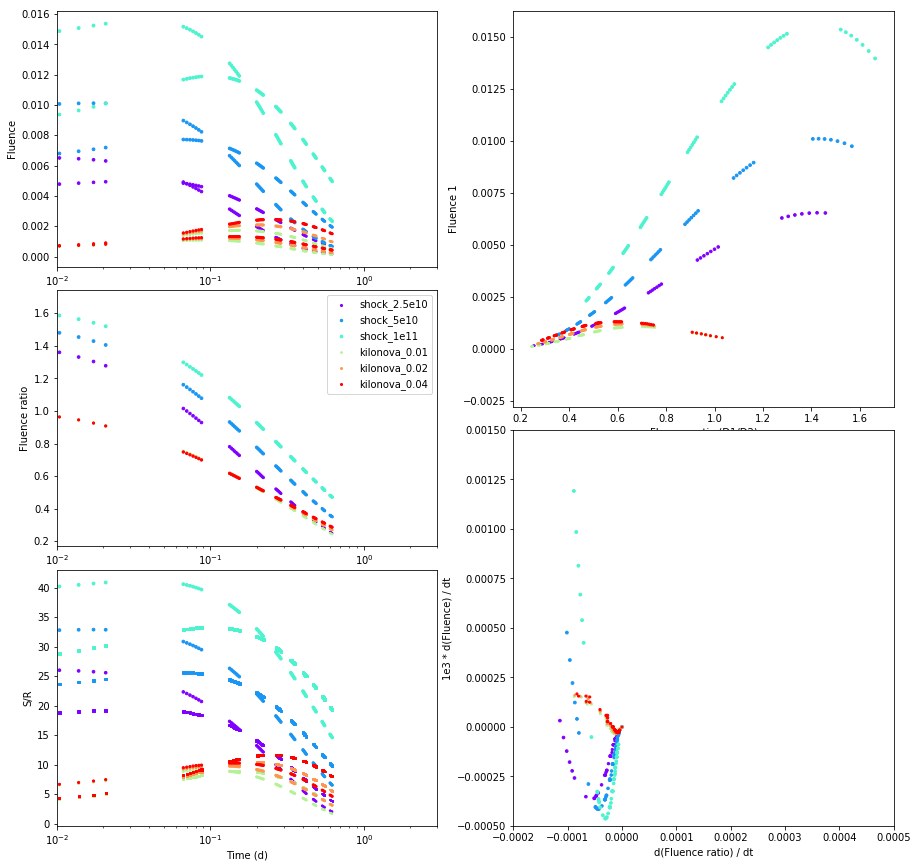

In [16]:
plot_lcs(lcs, labels)

In [6]:
# Now let's do it through a realistic image reconstruction.

lcs_im = []
for lc in lcs:
    lc_im = lightcurve_through_image(lc, exposure=300*u.s)
    lcs_im.append(lc_im)
# lcIIp = get_lightcurve("../astroduet/data/SNIIp_lightcurve_DUET.fits", distance=100e6*u.pc, 
#                        phase_start=0.5)

100%|██████████| 70/70 [00:24<00:00,  2.91it/s]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
100%|██████████| 70/70 [00:32<00:00,  2.17it/s]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
100%|██████████| 70/70 [00:32<00:00,  2.14it/s]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binn

100%|██████████| 70/70 [00:23<00:00,  2.96it/s]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
100%|██████████| 70/70 [00:25<00:00,  2.75it/s]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
100%|██████████| 70/70 [00:29<00:00,  2.37it/s]


shock_2.5e10
shock_5e10
shock_1e11
kilonova_0.01
kilonova_0.02
kilonova_0.04


/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/astropy/units/quantity.py:461: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


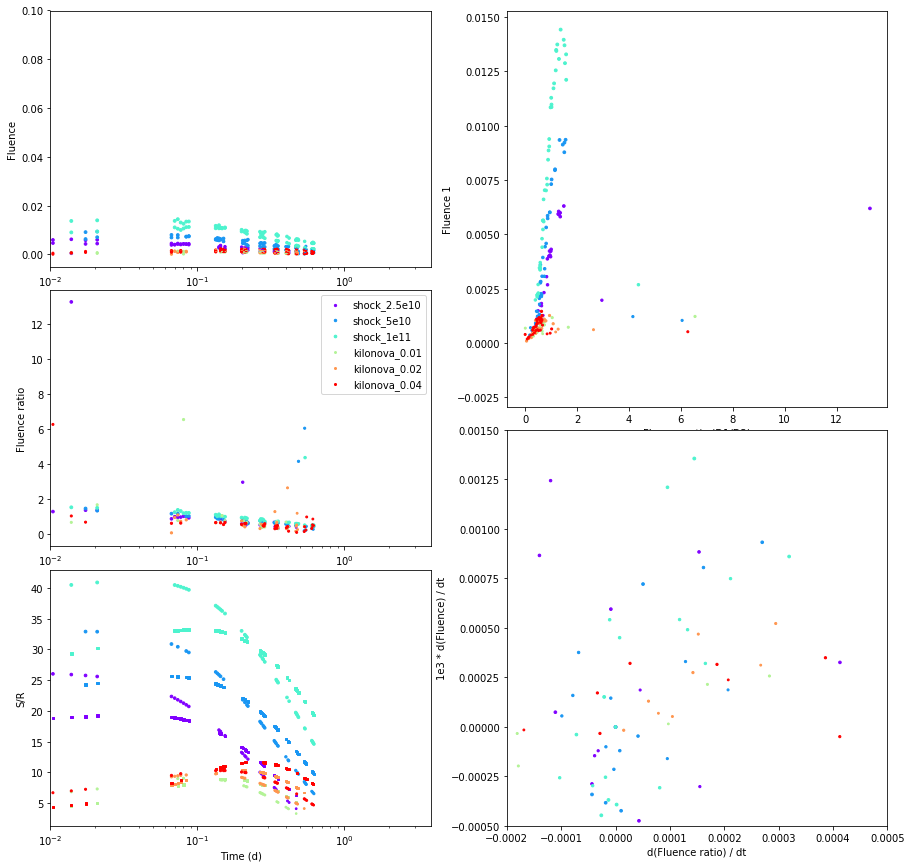

In [17]:
plot_lcs(lcs_im, labels)